# Fashion MNIST - Identifying Apparel Category

In [1]:
from theano.sandbox import cuda
cuda.use('gpu2')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): Ignoring call to use(2), GPU number 0 is already in use.


In [2]:
%matplotlib inline

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Importing the dataset
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
X_train = train.iloc[:, 1::].values
labels_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1::].values
labels_test = test.iloc[:, 0].values

In [5]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [6]:
# Feature Scaling (required for PCA and efficient for NNs)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Plotting sample images in test and train

In [7]:
# Reshaping train and test images
images_train = X_train.reshape(X_train.shape[0], 28, 28)
images_test = X_test.reshape(X_test.shape[0], 28, 28)

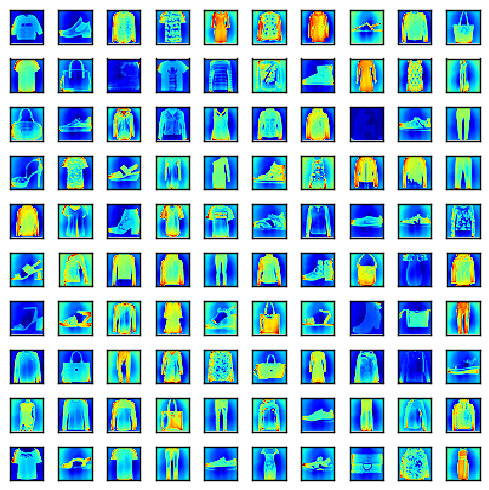

In [8]:
# Train images
plt.figure(figsize = (5, 5))
for i in range(0, 100):
    plt.subplot(10, 10, i+1)
    plt.imshow(images_train[i], interpolation = "none")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

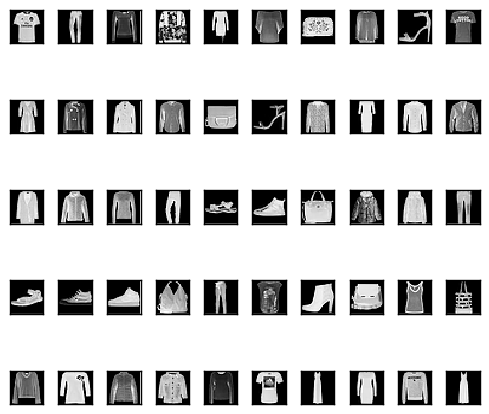

In [8]:
# Test images
plt.figure(figsize = (5, 5))
for i in range(0, 50):
    plt.subplot(5, 10, i+1)
    plt.imshow(images_test[i], interpolation = "none", cmap = "gray")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [9]:
images_test = np.expand_dims(images_test,1)
images_train = np.expand_dims(images_train,1)

In [10]:
# Encoding for label variable for use in Neural Networks
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features = [0])
labels_train = onehotencoder.fit_transform(labels_train.reshape(-1,1)).toarray()
labels_test = onehotencoder.fit_transform(labels_test.reshape(-1,1)).toarray()

In [11]:
np.shape(labels_test)

(10000, 10)

## Neural Network models - CNN and its variants

In [12]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.constraints import maxnorm

from keras import backend as K
K.set_image_dim_ordering('th')

Using Theano backend.


### Model 1 : Simple stacked CNN architecture

In [13]:
model = Sequential([
        Conv2D(32,(3,3), activation='relu', input_shape=(1,28,28)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
# Using Nesterov momentum with RMSprop
model.compile(optimizer = 'nadam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 10, 10)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 8, 8)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 4, 4)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

In [15]:
images_train.shape

(60000, 1, 28, 28)

In [16]:
# Fitting the CNN to the Training Set
history = model.fit(images_train, labels_train, validation_split = 0.2, batch_size = 100, epochs = 3)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 9s - loss: 0.4680 - acc: 0.8302 - val_loss: 0.3403 - val_acc: 0.8734
Epoch 2/3
48000/48000 [==============================] - 9s - loss: 0.2817 - acc: 0.8957 - val_loss: 0.2758 - val_acc: 0.9016
Epoch 3/3
48000/48000 [==============================] - 9s - loss: 0.2260 - acc: 0.9161 - val_loss: 0.2577 - val_acc: 0.9089


In [17]:
model.optimizer.lr /= 2

In [18]:
# Fitting the CNN to the Training Set
history = model.fit(images_train, labels_train, validation_split = 0.2, batch_size = 100, epochs = 3)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 9s - loss: 0.1911 - acc: 0.9281 - val_loss: 0.2749 - val_acc: 0.9068
Epoch 2/3
48000/48000 [==============================] - 9s - loss: 0.1638 - acc: 0.9387 - val_loss: 0.2733 - val_acc: 0.9088
Epoch 3/3
48000/48000 [==============================] - 9s - loss: 0.1388 - acc: 0.9481 - val_loss: 0.2921 - val_acc: 0.9110


As we see, the simple stacked CNN architecture has started to overfit and is already giving us a higher validation accuracy (~91%) than the most accurate benchmark model, which is an SVM (89.7%). At the end, the test accuracy for this model is also calculated.

In our next model version as shown below, we'll try one or more of Data Augmentation, BatchNorm and Dropout to regularize further and be able to train more epochs. BatchNorm was not effective on the original MNIST dataset. Hence, it will be interesting to see how it performs on this dataset.

### Model 2 : Data Augmentation + BatchNorm/Dropout

In [37]:
model = Sequential([
        Conv2D(32,(3,3), activation='relu', input_shape=(1,28,28)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
        ])
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 10, 10)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 8, 8)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 4, 4)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
__________

In [24]:
from keras.preprocessing import image

In [25]:
images_train = images_train.reshape(images_train.shape[0], 1, 28, 28)

In [26]:
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(images_train, labels_train, test_size = 0.2)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
X_train.shape

(48000, 1, 28, 28)

In [28]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_train, y_train, batch_size = 128)
val_batches = gen.flow(X_valid, y_valid, batch_size = 256)

In [29]:
val_batches

In [35]:
model.fit_generator(batches, (batches.n/batches.batch_size), epochs=5,
                   validation_data = val_batches, validation_steps = (val_batches.n/val_batches.batch_size))

Epoch 1/5
375/375 [==============================] - 13s - loss: 0.3588 - acc: 0.8680 - val_loss: 0.3741 - val_acc: 0.8647
Epoch 2/5
375/375 [==============================] - 13s - loss: 0.3556 - acc: 0.8683 - val_loss: 0.3843 - val_acc: 0.8601
Epoch 3/5
375/375 [==============================] - 12s - loss: 0.3453 - acc: 0.8708 - val_loss: 0.3644 - val_acc: 0.8686
Epoch 4/5
375/375 [==============================] - 13s - loss: 0.3472 - acc: 0.8695 - val_loss: 0.3481 - val_acc: 0.8753
Epoch 5/5
375/375 [==============================] - 12s - loss: 0.3422 - acc: 0.8717 - val_loss: 0.3529 - val_acc: 0.8733


In [34]:
model.optimizer.lr /= 5

The above two steps are used to experiment and gauge the learning nature of the model. Based on it, we build a learning rate decay function and run it for a fixed number of epochs to train the model optimally. The model is re-initialized before running the next two steps.

In [39]:
def lr_iter(start, stop, div_step) :
    while start >= stop:
        yield start
        start/= div_step

In [41]:
for i in lr_iter(0.001, 0.0002, 2):
    model.optimizer.lr = i
    print "Learning rate = "+str(i)
    model.fit_generator(batches, (batches.n/batches.batch_size), epochs=5,
                   validation_data = val_batches, validation_steps = (val_batches.n/val_batches.batch_size))

Learning rate = 0.001
Epoch 1/5
375/375 [==============================] - 13s - loss: 0.6475 - acc: 0.7559 - val_loss: 0.6849 - val_acc: 0.7414
Epoch 2/5
375/375 [==============================] - 12s - loss: 0.6598 - acc: 0.7523 - val_loss: 0.6239 - val_acc: 0.7649
Epoch 3/5
375/375 [==============================] - 12s - loss: 0.6473 - acc: 0.7546 - val_loss: 0.6373 - val_acc: 0.7575
Epoch 4/5
375/375 [==============================] - 12s - loss: 0.6463 - acc: 0.7572 - val_loss: 0.6130 - val_acc: 0.7690
Epoch 5/5
375/375 [==============================] - 12s - loss: 0.6407 - acc: 0.7594 - val_loss: 0.6230 - val_acc: 0.7692
Learning rate = 0.0005
Epoch 1/5
375/375 [==============================] - 12s - loss: 0.6441 - acc: 0.7564 - val_loss: 0.6090 - val_acc: 0.7686
Epoch 2/5
375/375 [==============================] - 12s - loss: 0.6482 - acc: 0.7588 - val_loss: 0.6569 - val_acc: 0.7543
Epoch 3/5
375/375 [==============================] - 12s - loss: 0.6463 - acc: 0.7582 - val_lo

## Predicting results

In [31]:
labels_pred = model.predict_classes(images_test)

28000/28000 [==============================] - 158s   


In [28]:
# Writing the results to a csv file
np.savetxt('results.csv', labels_pred)

In [29]:
labels_pred[0:5,]

array([2, 0, 9, 0, 3])